### Nonlinear Function

Given a $\phi$ and $\phi^{-1}$ (trained in Quantum autoencoder) such that $\phi^{-1}\circ\phi|\alpha\rangle = |\alpha\rangle$ and $dim(\phi|\alpha\rangle) < dim(|\alpha\rangle)$, we want to find a function $f$ such that $\phi^{-1}\circ f\circ\phi|\alpha_k\rangle = |\alpha_{k+1}\rangle$.

In [1]:
import matplotlib.pyplot as plt         
import tensorflow as tf
import numpy as np
import os
import pandas as pd

import sys

sys.path.append('..')
from utils import *
sys.path.remove('..')


#Some GPU configuration
#Always uses the 1st GPU avalible (if avalible) unless 1st line is uncommented, in which case no GPU is used

#tf.config.set_visible_devices([], 'GPU') #uncomment to set tensorflow to use CPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
elif len(physical_devices) == 0:
    print("Warning: No GPU detected.  Running tensorflow on CPU")

In [2]:
Phi = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial25e1000Phi.h5', compile=False)
Phi_inv = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial25e1000Phi_inv.h5', compile=False)

In [3]:
def predict_single_timestep(state, ideal_compression_3D=False, compression_phi=True, decompression_phi_inv=True):

    if ideal_compression_3D:
        assert (len(state) == 4), "State must be a four dimensional vector to be compressed"
        state = ideal_phi_3D(state)
        return ideal_phi_3D_inv(NonlinearEvolution(np.array([state,])).numpy()[0])
    if compression_phi:
        assert (len(state) == 4), "State must be a four dimensional vector to be compressed"
        state = Phi(np.array([state,]))
        if decompression_phi_inv:
            return Phi_inv(NonlinearEvolution(state)).numpy()[0]
        else:
            return NonlinearEvolution(state).numpy()[0]
    
    assert (len(state)==3), "State must be three dimensional if not being compressed"
        
    return NonlinearEvolution(np.array([state,])).numpy()[0]
    

In [4]:
def L2_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord=2, axis=-1)

def L2_with_unity_loss(y_true, y_pred):
    '''L2 loss augmented with extra loss for not having a norm of 1'''
    return tf.norm(y_true-y_pred, ord=2, axis=-1) + tf.abs(1. - tf.norm(y_pred, ord=2, axis=-1))

def ideal_phi_3D(state):
    assert (len(state)==4),'State must be 4 dimensions to compress to 3'
    r1 = np.sqrt(state[0]*state[0] + state[1]*state[1])
    r2 = np.sqrt(state[2]*state[2]+state[3]*state[3])
    phi1 = np.math.atan2(state[1],state[0])
    phi2 = np.math.atan2(state[3],state[2])
    return np.array([r1, r2, phi2-phi1])

def ideal_phi_3D_inv(state):
    assert (len(state) == 3),'Compressed state must be 3 dimensions to be decompressed'
    alpha = state[0]
    beta = 0.
    gamma = state[1]*np.cos(state[2])
    delta = state[1]*np.sin(state[2])
    return np.array([alpha, beta, gamma, delta])

In [5]:
def get_evolution_data(evolution_data, ideal_pre_compress_3D=False, pre_compress_phi=False):
    '''Read in evolution data from a csv file
    
    PARAMS:
    -------
    str evolution_data: Path to evolution datafile we wish to read
    bool ideal_pre_comrpess_3D: If true, uses ideal compression functions to 
                                  compress evolution data into specified dimension
    bool pre_compress_phi: If true, use the Phi neural net model to compress
                           evolution data
    
    RETURNS:
    --------
    tf.data.Dataset: Shuffled dataset of evolution values
    '''

    evolution_file = evolution_data
    
    with open(evolution_file, 'r') as f:
        data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
        
        if ideal_pre_compress_3D:
            data = np.array([ideal_phi_3D(x) for x in data])
        elif pre_compress_phi:
            data = Phi(data)
 
    
        pre_evolution = np.empty([len(data)-1, len(data[0])])
        post_evolution = np.empty([len(data)-1, len(data[0])])
   
        pre_evolution[0] = data[0]
        
        for i,k in enumerate(data[1:-1]):
            pre_evolution[i+1] = k
            post_evolution[i] = k
            
        post_evolution[-1] = data[-1]
        

        ds = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
            
        
        return ds.shuffle(100000, reshuffle_each_iteration=True)
    
    
#Train on entire evolutions, not just step-to-step?
#TODO: read in initial conditions randomly, not just sequentially
def get_multiple_evolutions(datadir, num_evolutions, train_evolutions, ideal_pre_compress_3D=False, pre_compress_phi=False):
    '''Read in the evolution of multiple initial conditions at once.  Each initial condition should 
    have its own csv file and be named in the format "evolution{}.csv", where {} indicates an integer.
    Note that there will be 1 fewer timesteps per evolution file than are present in the evolution file,
    since the last step does not have an evolution.
    
    PARAMS:
    -------
    str datadir: Path to directory containing evolution files.
    int num_evolutions: The number of initial conditions to read in.
    int train_evolutions: The number of initial conditions that should be treated as 
                          training evolutions
    
    RETURNS:
    --------
    (tf.data.Dataset, tf.data.Dataset): A tuple of the training and validation datasets, respectivley.
    '''
    
    pre_evolution = []
    post_evolution = []
    
    #Read training data
    for i in range(train_evolutions):
        with open(datadir+'evolution{}.csv'.format(i), 'r') as f:
            data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
            
            if ideal_pre_compress_3D:
                data = [ideal_phi_3D(x) for x in data]
            elif pre_compress_phi:
                data = Phi(data)
            
            pre_evolution.append(data[0])
            
            for k in data[1:-1]:
                pre_evolution.append(k)
                post_evolution.append(k)
            
            post_evolution.append(data[-1])
            
    train = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
    
    
    #Read test data
    pre_evolution = []
    post_evolution = []
    
    for i in range(train_evolutions, num_evolutions):
        with open(datadir+'evolution{}.csv'.format(i), 'r') as f:
            data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
            
            if ideal_pre_compress_3D:
                data = [ideal_phi_3D(x) for x in data]
            elif pre_compress_phi:
                data = Phi(data)
            
            
            pre_evolution.append(data[0])
            
            for k in data[1:-1]:
                pre_evolution.append(k)
                post_evolution.append(k)
            
            post_evolution.append(data[-1])
            
    test = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
    
    return train.shuffle(1000000, reshuffle_each_iteration=True), test.shuffle(1000000, reshuffle_each_iteration=True)

In [6]:
inputs = tf.keras.Input(shape=3)


nonlinear_layer_1 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_1')(inputs)
nonlinear_layer_2 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_2')(nonlinear_layer_1)
nonlinear_layer_3 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_3')(nonlinear_layer_2)
nonlinear_layer_4 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_4')(nonlinear_layer_3)
nonlinear_layer_5 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_5')(nonlinear_layer_4)
nonlinear_layer_6 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_6')(nonlinear_layer_5)
evolved = tf.keras.layers.Dense(3, activation='selu', name='evolved_state_layer')(nonlinear_layer_6)

NonlinearEvolution = tf.keras.Model(inputs=inputs, outputs=evolved)

In [6]:
#train_data = get_evolution_data('../../QuantumTeam/data/long_evolutions_(testing_timesteps)/big_evolve0p01.csv', pre_compress_phi=True)
#val_data = train_data.skip(int(0.8*100000)).batch(int(0.2*100000))
#train_data = train_data.take(int(0.8*100000)).batch(int(0.8*100000))

train_data, val_data = get_multiple_evolutions('../../QuantumTeam/data/5000inits_dt0p1/', 5000, 4500, pre_compress_phi=True)
train_data = train_data.batch(100000)
val_data = val_data.batch(100000)

In [8]:
NonlinearEvolution.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss=L2_loss, metrics=['mse', 'mae'])

In [ ]:
history = NonlinearEvolution.fit(train_data, validation_data=val_data, epochs=250)

In [30]:
write_history(history, NonlinearEvolution,loss='L2_loss',batch_size='100000', other_info={'dataset':'5000inits_dt0p1','validation':'500inits'})

'./datafiles/trial36.data'

In [10]:
append_history(history, trial=36, params={'Learning Rate':.0001})

In [11]:
NonlinearEvolution.save('./models/trial36e500.h5')

In [33]:
NonlinearEvolution = tf.keras.models.load_model('./models/trial36e500.h5', compile=False)

In [66]:
avg = 0
for i in range(1000):
    v = 2*np.random.random(4)-1
    v = 1/np.linalg.norm(v) * v
    w = 2*np.random.random(4)-1
    w = 1/np.linalg.norm(w) * w
    
    vpwnorm = np.linalg.norm(v+w)
    vpw = 1/vpwnorm * (v+w)

    vencode = Phi(np.array([v,])).numpy()[0]
    wencode = Phi(np.array([w,])).numpy()[0]
    vpwencode = Phi(np.array([vpw,])).numpy()[0]

    left = Phi_inv(np.array([NonlinearEvolution(np.array([vpwencode])).numpy()[0],]))

    right = 1/vpwnorm*(Phi_inv(np.array([NonlinearEvolution(np.array([vencode,])).numpy()[0],])) + Phi_inv(np.array([NonlinearEvolution(np.array([wencode,])).numpy()[0],])))
    
    avg += np.linalg.norm(left-right)
    
print(avg/1000)

#print("Norm of left:{}".format(np.linalg.norm(left)))
#print("Norm of right:{}".format(np.linalg.norm(right)))
#print("Norm of difference:{}".format(np.linalg.norm(left-right)))
#print(v)
#print(w)
#print(left)
#print(right)

0.00974338813504437


In [12]:
note_history(35,'./datafiles/', 'Only the first 2000 inits were used')

In [8]:
#loss_plot(32, savefig=False, skip_epochs=10)

## Visualizations

In [16]:
import qutip as qt


def predict_evolution(initial_cond, save_prediction=False, save_compressed=False, 
                      saved_name='./predicted_evolutions/newtest.csv', 
                      saved_compressed_name='./predicted_evolutions/newtest_compressed.csv', 
                      timesteps=1000):
    '''Use the currently loaded NonlinearF to predict an evolution
    given an initial condition.  The initial condition is compressed using Phi
    and the state is then evolved for the specified number of timesteps by NonlinearF
    without any decompression between steps.  Each evolved state is then decompressed seperatley.
    
    PARAMS:
    -------
    str initial_cond: Path to file containing initial condition (read as first point in a csv)
    list initial_cond: The initial condition to evolve
    bool save_prediction: Whether or not to save the prediction
    str saved_name: Name/path to file containing predicted evolution (if save_prediction is True)
    bool save_compressed: Whether or not to save the evolution before it is decompressed
    str save_compressed_name: Name/path to file containing compressed evolution prediction
    int timesteps: Number of timesteps to evolve for
    '''
    
    if type(initial_cond) == str:
        initial_cond = np.genfromtxt(initial_cond, delimiter=',', skip_header=1)[0,1:]
    
    if len(initial_cond)==4:
        initial_cond=Phi(np.array([initial_cond,])).numpy()[0]
    
    learned_evolution=np.empty([timesteps, 3])
    learned_evolution[0] = initial_cond
    
    for i in range(1,timesteps):
        learned_evolution[i] = predict_single_timestep(learned_evolution[i-1], compression_phi=False, decompression_phi_inv=False)
    
    if save_compressed:
        pd.DataFrame(learned_evolution).to_csv(saved_compressed_name)
    
    learned_evolution=Phi_inv(learned_evolution).numpy()
    
    if save_prediction:
        pd.DataFrame(learned_evolution).to_csv(saved_name)
        
    return learned_evolution


#TODO - change all the boolean switches into a dictionary for selection
def plot_dynamics(truth, predicted, savefig=False, timerange=500, timestart=0,
                  phispace=False, truespace=False, expectation=False, figname='dynamics.png', 
                  fontsize=16):
    '''Plot the dynamics (or state) of some evolution.  
    
    PARAMS:
    -------
    np.array truth,predicted: The true evolution and the predicted evolution.  Should be read from
                              a csv generated by pd.DataFrame with np.genfromtxt, or have an otherwise
                              identical structure to such an array
    bool phispace, truespace, expectation: Selects which space to plot.  Truespace refers to the 
                                           uncompressed 4 dimensional space which the Bloch sphere lives in, 
                                           phispace refers to the space in which NonlinearF learns its dynamics.
                                           Expectation refers to the space which QuTip uses to plot points on the 
                                           Bloch sphere.  If all of these are set to False, default to plotting the 
                                           'ideal' compressed space (r1, r2, relative phase).
    '''
    
    FONTSIZE=fontsize
    plt.rc('font', size=FONTSIZE)
    plt.rc('axes', titlesize=FONTSIZE,labelsize=FONTSIZE)
    plt.rc('legend', fontsize=FONTSIZE)
    plt.rc('xtick', labelsize=FONTSIZE)
    plt.rc('ytick', labelsize=FONTSIZE)
    plt.rc('figure', titlesize=FONTSIZE)
    
    
    
    if truespace:
        fig, ax = plt.subplots(4,1,figsize=(18,32))
        
        ax[0].plot(truth[timestart:timerange,0], truth[timestart:timerange,1], label='True')
        ax[0].plot(predicted[timestart:timerange,0], predicted[timestart:timerange,1], ls='--', label='Predicted')
        
        ax[1].plot(truth[timestart:timerange,0], truth[timestart:timerange,2])
        ax[1].plot(predicted[timestart:timerange,0], predicted[timestart:timerange,2], ls='--')
        
        ax[2].plot(truth[timestart:timerange,0], truth[timestart:timerange,3])
        ax[2].plot(predicted[timestart:timerange,0], predicted[timestart:timerange,3], ls='--')
        
        ax[3].plot(truth[timestart:timerange,0], truth[timestart:timerange,4])
        ax[3].plot(predicted[timestart:timerange,0], predicted[timestart:timerange,4], ls='--')
        
        ax[0].legend()
        ax[0].set_title(r'$\alpha$')
        ax[1].set_title(r'$\beta$')
        ax[2].set_title(r'$\gamma$')
        ax[3].set_title(r'$\delta$')
        ax[3].set_xlabel('Timestep')
        
    elif expectation:
        fig, ax = plt.subplots(3,1, figsize=(18,24))

        xs = []
        ys = []
        zs = []

        xspred = []
        yspred = []
        zspred = []

        for i in range(timestart, timerange):
            state = np.array([truth[i,1]+truth[i,2]*1j, truth[i,3]+truth[i,4]*1j])
            state = qt.Qobj(state)

            predstate = np.array([predicted[i,1] + predicted[i,2]*1j, predicted[i,3] + predicted[i,4]*1j])
            predstate = qt.Qobj(predstate)

            for t in [state]:
                xs.append(qt.expect(qt.sigmax(), t))
                ys.append(qt.expect(qt.sigmay(), t))
                zs.append(qt.expect(qt.sigmaz(), t))


            for t in [predstate]:
                xspred.append(qt.expect(qt.sigmax(), t))
                yspred.append(qt.expect(qt.sigmay(), t))
                zspred.append(qt.expect(qt.sigmaz(), t))


        ax[0].plot(np.arange(timestart,timerange), xs)
        ax[1].plot(np.arange(timestart,timerange), ys)
        ax[2].plot(np.arange(timestart,timerange), zs)

        ax[0].plot(np.arange(timestart,timerange), xspred)
        ax[1].plot(np.arange(timestart,timerange), yspred)
        ax[2].plot(np.arange(timestart,timerange), zspred)

        ax[0].set_title(r'$\langle\psi|\hat{\sigma_x}|\psi\rangle$')
        ax[1].set_title(r'$\langle\psi|\hat{\sigma_y}|\psi\rangle$')
        ax[2].set_title(r'$\langle\psi|\hat{\sigma_z}|\psi\rangle$')
    
    elif not phispace:
        fig, ax = plt.subplots(3,1,figsize=(18,24))
        
        
        r1 = np.sqrt(truth[timestart:timerange,1]**2 + truth[timestart:timerange,2]**2)
        r2 = np.sqrt(truth[timestart:timerange,3]**2 + truth[timestart:timerange,4]**2)
        theta = np.arctan2(truth[timestart:timerange,4],truth[timestart:timerange,3]) - np.arctan2(truth[timestart:timerange,2],truth[timestart:timerange,1])

        r1l = np.sqrt(predicted[timestart:timerange,1]**2 + predicted[timestart:timerange,2]**2)
        r2l = np.sqrt(predicted[timestart:timerange,3]**2 + predicted[timestart:timerange,4]**2)
        thetal = np.arctan2(predicted[timestart:timerange,4],predicted[timestart:timerange,3]) - np.arctan2(predicted[timestart:timerange,2],predicted[timestart:timerange,1])
        
        ax[0].plot(truth[timestart:timerange,0], r1, label='True')
        ax[0].plot(predicted[timestart:timerange,0], r1l, ls='--', label='Predicted')

        ax[1].plot(truth[timestart:timerange,0],r2)
        ax[1].plot(predicted[timestart:timerange,0],r2l, ls='--')

        ax[2].plot(truth[timestart:timerange,0],theta)
        ax[2].plot(predicted[timestart:timerange,0],thetal, ls='--')

        ax[0].legend()
        ax[0].set_title(r'$r_1 = \sqrt{\alpha^2+\beta^2}$')
        ax[1].set_title(r'$r_2 = \sqrt{\gamma^2+\delta^2}$')
        ax[2].set_title(r'$\theta = \arctan\left(\frac{\delta}{\gamma}\right) - \arctan\left(\frac{\beta}{\alpha}\right)$')

        ax[2].set_xlabel('Timestep')
        
        
    else:
        fig, ax = plt.subplots(3,1,figsize=(18,24))
        
        
        compressed_truth = Phi(truth[:,1:]).numpy()
        compressed_pred = Phi(predicted[:,1:]).numpy()

        ax[0].plot(truth[timestart:timerange,0], compressed_truth[timestart:timerange,0], label='True')
        ax[0].plot(predicted[timestart:timerange,0], compressed_pred[timestart:timerange,0], ls='--',label='Predicted')

        ax[1].plot(truth[timestart:timerange,0],compressed_truth[timestart:timerange,1])
        ax[1].plot(predicted[timestart:timerange,0],compressed_pred[timestart:timerange,1], ls='--')

        ax[2].plot(truth[timestart:timerange,0],compressed_truth[timestart:timerange,2])
        ax[2].plot(predicted[timestart:timerange,0],compressed_pred[timestart:timerange,2], ls='--')

        ax[0].legend()
        ax[0].set_title(r'$\phi|\alpha\rangle[0]$')
        ax[1].set_title(r'$\phi|\alpha\rangle[1]$')
        ax[2].set_title(r'$\phi|\alpha\rangle[2]$')
        ax[2].set_xlabel('Timestep')
        
    if savefig:
        fig.savefig(figname, bbox_inches='tight', transparent=False)
        
    
        
#Create images to be used for animations of the evolution
#VERY SLOW, took about an hour to create 1000 images on my laptop

#After running, use ffmpeg to stitch the frames together (wrapped inside create_animation.sh)

def create_animation_frames(truth, predicted, framedir='./anim/', timesteps=500, view=[-60,30]):

    b = qt.Bloch()
    
    b.view = view

    b.vector_color = ['g', '#000000']
    b.point_color = ['g', '#000000']
    b.point_marker = ['o']


    for i in range(timesteps):
    
        #Clear vectors, keep points
        b.vectors = []

        #Plot true evolution in green

        state = np.array([truth[i,1]+truth[i,2]*1j, truth[i,3]+truth[i,4]*1j])
        state = qt.Qobj(state)
        b.add_states([state])
        b.add_states([state], kind='point')


        #Plot learned evolution in black

        state = np.array([predicted[i,1]+predicted[i,2]*1j, predicted[i,3]+predicted[i,4]*1j])
        state = qt.Qobj(state)
        b.add_states([state])
        b.add_states([state], kind='point')
        
        b.save(dirc=framedir)

In [13]:
predict_evolution('../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv', save_prediction=True, saved_name='./predicted_evolutions/learnedt34_.csv', save_compressed=True, saved_compressed_name='./predicted_evolutions/learnedt36_compressed.csv', timesteps=5000)

array([[ 1.0007367 ,  0.0028226 ,  0.00116147,  0.00240916],
       [ 0.99017954, -0.05752831, -0.08335832, -0.09629864],
       [ 0.96085274, -0.1107166 , -0.17087327, -0.18135048],
       ...,
       [ 0.5598208 , -0.5855723 ,  0.40094978, -0.4265623 ],
       [ 0.5112656 , -0.68034476,  0.2977346 , -0.43426234],
       [ 0.44918334, -0.765491  ,  0.18269885, -0.42276573]],
      dtype=float32)

In [57]:
#Read in evolution data for plotting 
data = np.genfromtxt("../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv", delimiter=",", skip_header=1)
learned = np.genfromtxt('./predicted_evolutions/learnedt36.csv', delimiter=",", skip_header=1)

In [59]:
#Check that magnitude is approximately 1
timerange=1000
r1l = np.sqrt(learned[:timerange,1]**2 + learned[:timerange,2]**2)
r2l = np.sqrt(learned[:timerange,3]**2 + learned[:timerange,4]**2)
thetal = np.arctan2(learned[:timerange,4],learned[:timerange,3]) - np.arctan2(learned[:timerange,2],learned[:timerange,1])

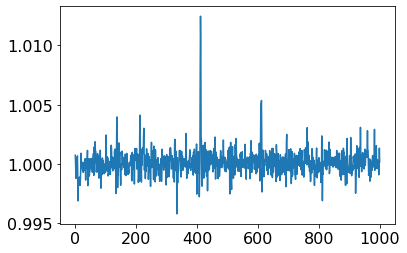

In [60]:
plt.plot(learned[:1000,0], np.sqrt(r1l[:1000]**2+r2l[:1000]**2))

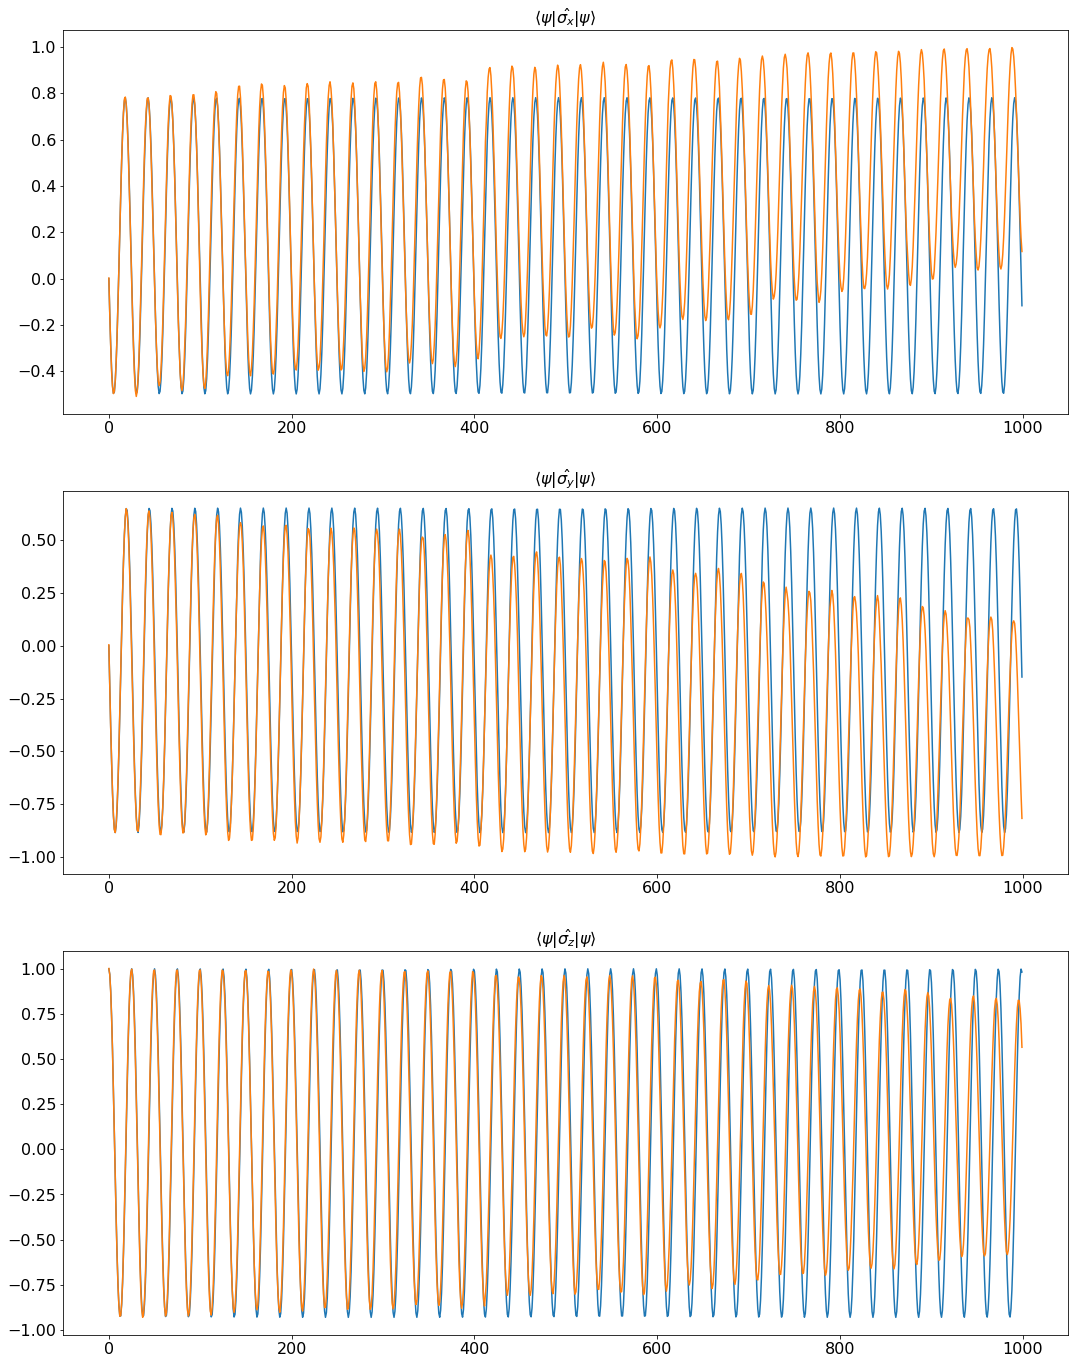

In [58]:
plot_dynamics(data, learned, phispace=False, truespace=False, expectation=True, savefig=False,figname='./figures/trial36_ts4t5000.png', timerange=1000, timestart=0)

In [ ]:
create_animation_frames(data, learned, timesteps=1000)

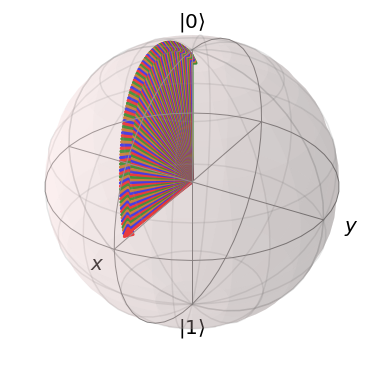

In [83]:
#The actual evolution

bloch = qt.Bloch()

for i in range(100):
    state = np.array([data[i,1]+data[i,2]*1j, data[i,3]+data[i,4]*1j])
    bit=qt.Qobj(state)
    bloch.add_states([bit])
    
bloch.render()

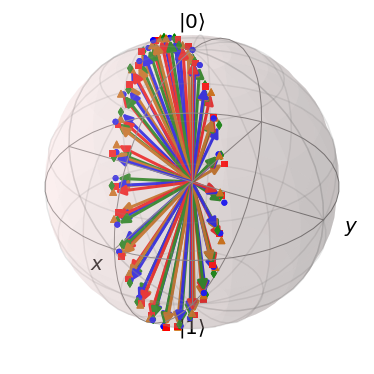

In [39]:
#The predicted evolution

bloch = qt.Bloch()

for i in range(100):
    state = np.array([learned[i,1]+learned[i,2]*1j, learned[i,3]+learned[i,4]*1j])
    bit=qt.Qobj(state)
    bloch.add_states([bit])
    bloch.add_states([bit], kind='point')
    
bloch.render()

In [ ]:
b = qt.Bloch()
b.point_color=['g']
b.point_marker=['o']


for i in range(100):
    with open('../../QuantumTeam/data/5000inits_dt0p1/evolution{}.csv'.format(i), 'r') as f:
        for k in f.readlines()[1:300]:
            i = [float(x) for x in k.strip().split(',')[1:]]
            state = np.array([i[0]+i[1]*1j, i[2]+i[3]*1j])
            bit = qt.Qobj(state)
            b.add_states([bit], kind='point')
            #print(k.strip().split(','))
            
b.render()

### Old/unused functions

May still be useful as refrence/figure out what we were doing before, but not immidietley useful to the program and just cluttering up the notebook otherwise

In [20]:
##NOTE: The 2D compression tools do not work, only the 3D ones
def ideal_phi_2D(states):
    theta = np.math.atan2(states[1],states[0]) - np.math.atan2(states[3],states[2])
    r = np.sqrt(states[0]*states[0]+states[1]*states[1])
    return np.array([r, theta])

def ideal_phi_2D_inv(compressed):
    r, theta = compressed[0], compressed[1]
    
    alpha = r*np.cos(theta)
    beta = r*np.sin(theta)
    gamma = np.sqrt(1-r*r)
    delta = 0.
    return np.array([alpha, beta, gamma, delta])





#These compressions fail because sign information on the fourth dimension is lost w/ the square root

def ideal_phi_3D(states):
    return np.array([states[0], states[1], states[2]])

def ideal_phi_3D_inv(compressed):
    diff = 1-compressed[0]*compressed[0]-compressed[1]*compressed[1]-compressed[2]*compressed[2]
    if diff >=0.:
        fourth_component = np.sqrt(diff)
    else:
        fourth_component = 0.
    return np.array([compressed[0], compressed[1], compressed[2], fourth_component])


def get_relative_phase(vector):
    '''Returns the relative phase between
    the two complex components of a two
    complex dimensional vector
    Assumes the vector is passed in as a 
    four dimensional real row vector of form
    [real1, imag1, real2, imag2]
    '''
    

    #Tensorflow likes to return a list of a single
    #element sometimes, which breaks this function
    #This does not happen during training, only when
    #manually run on a single vector
    if vector.shape == (4,):
        return tf.atan2(vector[1], vector[0])%(2*np.pi) - tf.atan2(vector[3], vector[2])%(2*np.pi)

    return tf.atan2(vector[:,1],vector[:,0])%(2*np.pi) - tf.atan2(vector[:,3],vector[:,2])%(2*np.pi)
